# Data Gather

### **library imports**

In [55]:
import cv2
import mediapipe as mp
import numpy as np
import csv
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import os  # Add import for os module
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import pandas as pd

### **Initialize MediaPipe Pose**

In [56]:
'''This script uses MediaPipe to process video frames for pose estimation.'''
mp_pose = mp.solutions.pose  # Access MediaPipe's pose solution
mp_drawing = mp.solutions.drawing_utils  # Utility for drawing landmarks on frames
pose = mp_pose.Pose(
    static_image_mode=False,  # Process video frames in a continuous stream
    min_detection_confidence=0.5,  # Minimum confidence for detecting landmarks
    min_tracking_confidence=0.5  # Minimum confidence for tracking landmarks
)

### **Function to calculate the angle between two points in the XOY plane**

In [57]:
def angle_from_origin_xoy(p1, p2):
    '''Calculate the angle between two points in the XOY plane.
    Args:
        p1 (tuple): Coordinates of the first point (x1, y1).
        p2 (tuple): Coordinates of the second point (x2, y2).
        Returns:
        float: The angle in degrees between the line connecting the two points and the x-axis.'''
    delta_x = p2[0] - p1[0]
    delta_y = p1[1] - p2[1]  # Invert y-axis for Cartesian coordinates
                
    if delta_x == 0 and delta_y == 0:
        return 0.0  # Handle identical points
                
    angle = np.degrees(np.arctan2(delta_y, delta_x))
    angle = abs(angle)  # Convert -180 to -90 to 90 to 180
    if angle > 90:  # Second and third quadrants
        angle = 180 - angle  # Map 90-180 to 90-0            
    return angle

### **Function to process video and calculate angles**

In [58]:
def process_video_and_calculate_angles(video_path, landmark_to_compare, landmark_name, classification_class):
    """
    Process a video to calculate angles between a reference point and a specified landmark.
    Args:
        video_path (str): Path to the input video file.
        landmark_to_compare (int): Index of the landmark to compare against the reference point.
        landmark_name (str): Name of the landmark for labeling.
        classification_class (str): Classification class for the landmark.
    Returns:
        pd.DataFrame: DataFrame containing frame number, angle, landmark name, and classification.
    """

    # Initialize an empty DataFrame with VideoName column
    angles_data = pd.DataFrame(columns=["Frame", "Angle (degrees)"])
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video.")
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    scale = (800, 600)
    frame_atual = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame is None:
            print("End of video or cannot read the frame.")
            break

        imagem_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resultado = pose.process(imagem_rgb)

        if resultado.pose_landmarks:
            mp_drawing.draw_landmarks(frame, resultado.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Get reference point (midpoint between hips)
            left_hip = resultado.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
            right_hip = resultado.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
            ref_x = (left_hip.x + right_hip.x) / 2
            ref_y = (left_hip.y + right_hip.y) / 2

            # Use the index directly to get the specified landmark
            target_landmark = resultado.pose_landmarks.landmark[int(landmark_to_compare)]

            # Convert normalized coordinates to image coordinates
            h, w, _ = frame.shape
            ref_pt = (int(ref_x * w), int(ref_y * h))
            target_pt = (int(target_landmark.x * w), int(target_landmark.y * h))

            # Draw points
            cv2.circle(frame, ref_pt, 8, (0, 255, 0), -1)
            cv2.circle(frame, target_pt, 8, (0, 0, 255), -1)

            # Draw line
            cv2.line(frame, ref_pt, target_pt, (255, 255, 0), 2)

            # Calculate angle
            angulo = angle_from_origin_xoy(ref_pt, target_pt)

            if angulo is not None:
                # Append the new row to the DataFrame
                angles_data.loc[len(angles_data)] = [frame_atual, angulo]

                # Display angle
                cv2.putText(frame, f"Angle: {angulo:.1f} deg", (target_pt[0]+10, target_pt[1]-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
            else:
                print(f"Frame {frame_atual}: Unable to calculate angle.")

        frame_resized = cv2.resize(frame, scale)
        cv2.imshow("Angle Visualization", frame_resized)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_atual += 1
    cap.release()
    cv2.destroyAllWindows()
    
    angles_data["Landmark"] = landmark_name
    angles_data["Classification"] = classification_class
    angles_data["Video Name"] = os.path.basename(video_path)  # Add video name to DataFrame
    
    return angles_data


### **Function to process csv and normalize data**

In [59]:
import os

def process_angles_data(data): 
    """
    Process angles data to filter, normalize, and calculate velocity and acceleration.
    Args:
        data (pd.DataFrame): DataFrame containing angles data with columns 'Frame' and 'Angle (degrees)'.
    Returns:
        pd.DataFrame: Processed DataFrame with additional columns for filtered angles, velocity, and acceleration.
    """

    # Butterworth low-pass filter function
    def butter_lowpass_filter(data, cutoff, fs, order):
        b, a = butter(order, cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)

    # Define filter parameters
    order = 4
    cutoff = 0.2
    fps = 30

    # Apply the filter to the Angle (degrees) column
    data['Filtered Angle (degrees)'] = butter_lowpass_filter(data['Angle (degrees)'], cutoff, fps, order)

    # Calculate velocity and acceleration
    data['velocity'] = np.gradient(data['Filtered Angle (degrees)'], data['Frame'])
    data['acceleration'] = np.gradient(data['velocity'], data['Frame'])

    # Normalize velocity and acceleration
    scaler = MinMaxScaler()
    data[['velocity_normalized', 'acceleration_normalized']] = scaler.fit_transform(
        data[['velocity', 'acceleration']]
    )

    # Add a new column to convert frames to seconds
    data['Time (seconds)'] = data['Frame'] / fps

    return data

### **Join frames For Each Landmark Video to get STD e Medium**

In [60]:
def process_video_stats(df_normalized_data, data_path):
    '''Process video statistics to calculate summary statistics for each second.
    Args:
        df_normalized_data (pd.DataFrame): DataFrame containing normalized data with columns for angles, velocity, and acceleration.
    Returns:
        pd.DataFrame: DataFrame containing summary statistics for each second of the video.'''


    # Group by each second
    grouped = df_normalized_data.groupby(df_normalized_data['Time (seconds)'].astype(int))
    stats = grouped.agg({
            'Filtered Angle (degrees)': ['std', 'mean', 'median', 'min', 'max'],
            'velocity': ['std', 'mean', 'median', 'min', 'max'],
            'acceleration': ['std', 'mean', 'median', 'min', 'max']
        }).reset_index()
    # Flatten MultiIndex columns
    stats.columns = ['Time (seconds)',
                        'angle_std', 'angle_medium', 'angle_median', 'angle_min', 'angle_max',
                        'velocity_std', 'velocity_medium', 'velocity_median', 'velocity_min', 'velocity_max',
                        'acceleration_std', 'acceleration_medium', 'acceleration_median', 'acceleration_min', 'acceleration_max']
    stats['Classification'] = df_normalized_data['Classification']
    stats['Landmark'] = df_normalized_data['Landmark']
    stats['Video Name'] = df_normalized_data['Video Name']  # Use the first video name for all rows
    
    # Generate processed file path using landmark and classification
    landmark = df_normalized_data['Landmark'].iloc[0]
    classification = df_normalized_data['Classification'].iloc[0]
    processed_landmark_video_path = f"{data_path}/{landmark}_{classification}_stats.csv"
    stats.to_csv(processed_landmark_video_path, index=False)

    # Save the stats DataFrame to CSV
    stats.to_csv(processed_landmark_video_path, index=False)
    print(f"Processed statistics saved to {processed_landmark_video_path}")
    return stats

### **Join all processed CSV files from the videos folder**

In [61]:
def join_csv_files(folder):
    """
    Join all CSV files in the specified folder into a single DataFrame.
    Args:
        video_folder (str): Path to the folder containing CSV files.
    Returns:
        pd.DataFrame: DataFrame containing combined data from all CSV files.
        string: Saves the combined DataFrame to a CSV file named "all_landmarks_data_Processed_combined.csv"."
    """
    import glob
    import pandas as pd

    # Find all CSV files in the specified folder
    csv_files = glob.glob(os.path.join(folder, "*_stats.csv"))

    # Read and concatenate all CSV files
    df_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
    
    # Save the combined stats DataFrame to a CSV file
    all_stats_csv_path = os.path.join(folder, "all_landmarks_data_Processed_combined.csv")
    df_all.to_csv(all_stats_csv_path, index=False)
    print(f"Combined stats CSV saved to: {all_stats_csv_path}")
    return df_all, all_stats_csv_path

### **Joint All stats Per video, Second and Landmark**

In [69]:
def reshape_dataframe(df):
    """
    Reshape the DataFrame to have one row per video per second, with stats for each landmark separated.
    Args:
        df (pd.DataFrame): Original DataFrame containing stats for all landmarks.
    Returns:
        pd.DataFrame: Reshaped DataFrame.
    """
    reshaped_data = []
    grouped = df.groupby(['Time (seconds)', 'Video Name', 'Classification'])
    
    for (time, video_name, classification), group in grouped:
        row = {'Time (seconds)': time, 'Video Name': video_name, 'Classification': classification}
        for landmark in group['Landmark'].unique():
            landmark_data = group[group['Landmark'] == landmark]
            for col in ['angle_std', 'angle_medium', 'angle_median', 'angle_min', 'angle_max',
                        'velocity_std', 'velocity_medium', 'velocity_median', 'velocity_min', 'velocity_max',
                        'acceleration_std', 'acceleration_medium', 'acceleration_median', 'acceleration_min', 'acceleration_max']:
                row[f"{col}_{landmark}"] = landmark_data[col].values[0] if not landmark_data[col].empty else None
        reshaped_data.append(row)
    
    reshaped_df = pd.DataFrame(reshaped_data)
    
    return reshaped_df

### **Define the landmarks of interest**

In [63]:
landmarks_ids = {
    "head": 0,  # Head (nose landmark)
    "left_wrist": 15,  # Left wrist
    "right_wrist": 16,  # Right wrist
    "left_ankle": 27,  # Left ankle
    "right_ankle": 28  # Right ankle
}
print("Landmarks de interesse definidos:", landmarks_ids)


Landmarks de interesse definidos: {'head': 0, 'left_wrist': 15, 'right_wrist': 16, 'left_ankle': 27, 'right_ankle': 28}


### **Gather data from videos**

In [70]:
videos_folder = '.\\Videos\\'
data_folder = '.\\Data\\'
videos = {
    'impro_free.MP4': 'direct',
    'Phrase3.mp4': 'indirect',
}

def get_videos_data(videos, landmarks, data_folder, videos_folder):
    for video, classification in videos.items():
        for landmark_name, landmark_index in landmarks.items():
            angles_data = process_video_and_calculate_angles(videos_folder + video, landmark_index, landmark_name, classification)
            df_normalized_data = process_angles_data(angles_data)
            df_stats = process_video_stats(df_normalized_data, data_folder)
    
#get_videos_data(videos, landmarks_ids, data_folder, videos_folder)
df_all, _ = join_csv_files(data_folder)
df_all = reshape_dataframe(df_all)
# Save the reshaped DataFrame to a CSV file
reshaped_csv_path = os.path.join(data_folder, "reshaped_landmarks_data.csv")
df_all.to_csv(reshaped_csv_path, index=False)



Combined stats CSV saved to: .\Data\all_landmarks_data_Processed_combined.csv


### **Print DataFrame statistics**

In [ ]:
df_all.describe(include='all')

In [ ]:
df_all.info()

# Training

### **Necessary Imports**

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [71]:
# Features and target

# List of all feature columns as strings
feature_columns = [
    'angle_std_head', 'angle_medium_head', 'angle_median_head', 'angle_min_head', 'angle_max_head',
    'velocity_std_head', 'velocity_medium_head', 'velocity_median_head', 'velocity_min_head', 'velocity_max_head',
    'acceleration_std_head', 'acceleration_medium_head', 'acceleration_median_head', 'acceleration_min_head', 'acceleration_max_head',
    'angle_std_left_ankle', 'angle_medium_left_ankle', 'angle_median_left_ankle', 'angle_min_left_ankle', 'angle_max_left_ankle',
    'velocity_std_left_ankle', 'velocity_medium_left_ankle', 'velocity_median_left_ankle', 'velocity_min_left_ankle', 'velocity_max_left_ankle',
    'acceleration_std_left_ankle', 'acceleration_medium_left_ankle', 'acceleration_median_left_ankle', 'acceleration_min_left_ankle', 'acceleration_max_left_ankle',
    'angle_std_left_wrist', 'angle_medium_left_wrist', 'angle_median_left_wrist', 'angle_min_left_wrist', 'angle_max_left_wrist',
    'velocity_std_left_wrist', 'velocity_medium_left_wrist', 'velocity_median_left_wrist', 'velocity_min_left_wrist', 'velocity_max_left_wrist',
    'acceleration_std_left_wrist', 'acceleration_medium_left_wrist', 'acceleration_median_left_wrist', 'acceleration_min_left_wrist', 'acceleration_max_left_wrist',
    'angle_std_right_ankle', 'angle_medium_right_ankle', 'angle_median_right_ankle', 'angle_min_right_ankle', 'angle_max_right_ankle',
    'velocity_std_right_ankle', 'velocity_medium_right_ankle', 'velocity_median_right_ankle', 'velocity_min_right_ankle', 'velocity_max_right_ankle',
    'acceleration_std_right_ankle', 'acceleration_medium_right_ankle', 'acceleration_median_right_ankle', 'acceleration_min_right_ankle', 'acceleration_max_right_ankle',
    'angle_std_right_wrist', 'angle_medium_right_wrist', 'angle_median_right_wrist', 'angle_min_right_wrist', 'angle_max_right_wrist',
    'velocity_std_right_wrist', 'velocity_medium_right_wrist', 'velocity_median_right_wrist', 'velocity_min_right_wrist', 'velocity_max_right_wrist',
    'acceleration_std_right_wrist', 'acceleration_medium_right_wrist', 'acceleration_median_right_wrist', 'acceleration_min_right_wrist', 'acceleration_max_right_wrist'
]


X = df_all[feature_columns]
y = df_all['Classification']

### **Gather all processed CSVs and Split Data for Training**

In [89]:
# Separate classes
df_direct = df_all[df_all['Classification'] == 'direct']
df_indirect = df_all[df_all['Classification'] == 'indirect']

# Resample to balance classes
df_direct_resampled = resample(df_direct, replace=True, n_samples=len(df_indirect), random_state=42)
df_balanced = pd.concat([df_direct_resampled, df_indirect])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Define features and target for balanced data
X_balanced = df_balanced[X.columns]
y_balanced = df_balanced['Classification']

# Split balanced data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Correct scaling process
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform training data
X_test = scaler.transform(X_test)       # Transform test data using the same scaler

### **Create and Build Model**

In [91]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and report
y_pred = rf.predict(X_test)

### **Test Model**

              precision    recall  f1-score   support

      direct       1.00      1.00      1.00         3
    indirect       1.00      1.00      1.00         4

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



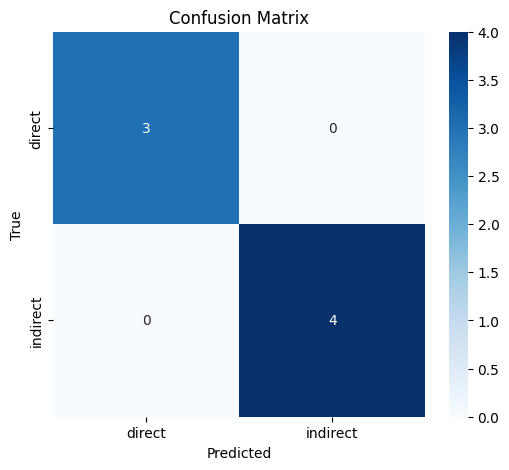

Feature Importances:
acceleration_min_right_wrist: 0.1345
acceleration_median_right_ankle: 0.0741
acceleration_std_head: 0.0577
velocity_std_right_wrist: 0.0439
acceleration_std_right_wrist: 0.0432
acceleration_min_head: 0.0338
acceleration_max_right_wrist: 0.0337
angle_max_left_ankle: 0.0326
acceleration_std_right_ankle: 0.0292
angle_std_right_wrist: 0.0284
acceleration_min_right_ankle: 0.0257
angle_max_right_ankle: 0.0256
angle_medium_left_ankle: 0.0250
velocity_std_head: 0.0247
angle_median_right_ankle: 0.0221
angle_std_right_ankle: 0.0193
velocity_max_head: 0.0185
velocity_max_left_ankle: 0.0171
angle_median_left_ankle: 0.0165
acceleration_max_head: 0.0163
angle_median_left_wrist: 0.0160
velocity_min_right_ankle: 0.0154
velocity_min_left_ankle: 0.0146
velocity_std_right_ankle: 0.0128
velocity_max_right_wrist: 0.0120
velocity_median_left_ankle: 0.0119
velocity_min_left_wrist: 0.0106
angle_medium_right_ankle: 0.0104
angle_min_right_ankle: 0.0102
angle_max_left_wrist: 0.0099
angle_std

C:\Users\asus\AppData\Local\Temp\ipykernel_26852\279346702.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


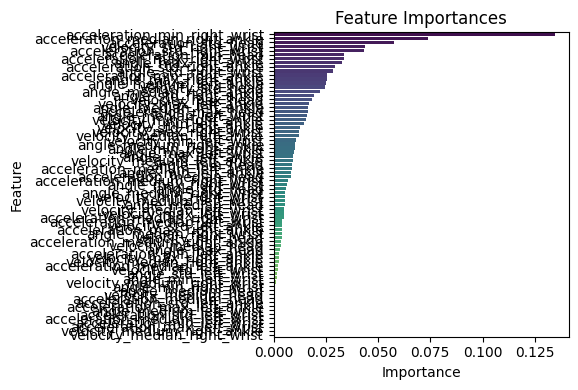

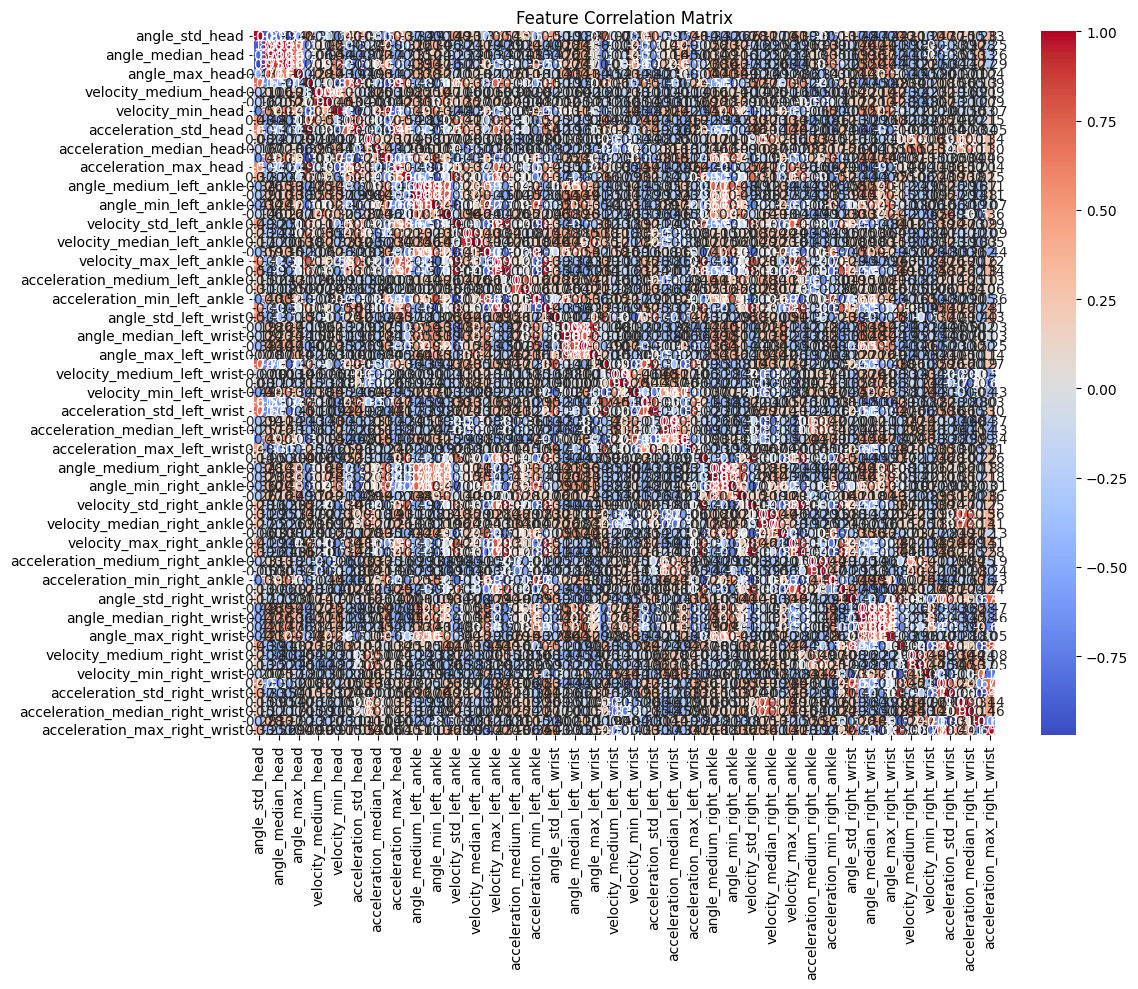

In [94]:
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features with increased figure size for better visibility
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

### **Create and Build Model with Hyperparameter Tuning**

In [95]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search using the balanced and scaled data
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Use the best model
rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Predict and report
y_pred = rf.predict(X_test)

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


### **Test Model with Hyperparameter Tuning**

              precision    recall  f1-score   support

      direct       0.75      1.00      0.86         3
    indirect       1.00      0.75      0.86         4

    accuracy                           0.86         7
   macro avg       0.88      0.88      0.86         7
weighted avg       0.89      0.86      0.86         7



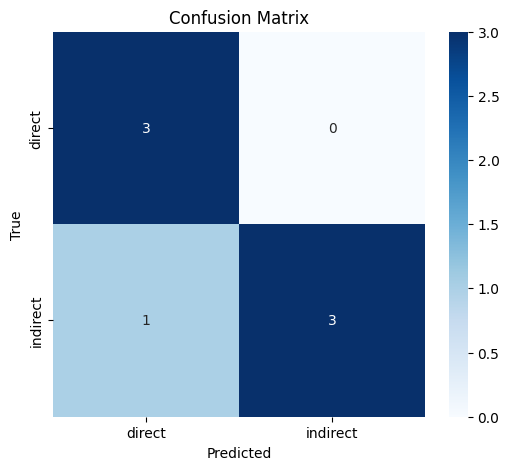

Feature Importances:
acceleration_min_right_wrist: 0.1157
acceleration_std_right_wrist: 0.0641
acceleration_std_head: 0.0579
angle_max_left_ankle: 0.0518
velocity_std_right_wrist: 0.0419
acceleration_max_right_wrist: 0.0390
angle_medium_left_ankle: 0.0367
velocity_std_head: 0.0349
acceleration_median_right_ankle: 0.0339
acceleration_max_head: 0.0326
acceleration_std_right_ankle: 0.0280
velocity_min_right_ankle: 0.0277
acceleration_min_right_ankle: 0.0271
velocity_std_right_ankle: 0.0256
velocity_max_left_ankle: 0.0239
angle_std_right_ankle: 0.0218
velocity_median_left_ankle: 0.0209
velocity_min_left_ankle: 0.0164
angle_max_left_wrist: 0.0145
angle_std_right_wrist: 0.0144
acceleration_min_head: 0.0144
velocity_max_right_wrist: 0.0137
angle_median_right_ankle: 0.0135
acceleration_medium_right_wrist: 0.0133
angle_min_right_ankle: 0.0128
angle_median_left_ankle: 0.0120
angle_std_head: 0.0117
angle_medium_right_ankle: 0.0112
velocity_min_right_wrist: 0.0109
angle_min_head: 0.0109
angle_medi

C:\Users\asus\AppData\Local\Temp\ipykernel_26852\1907170430.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


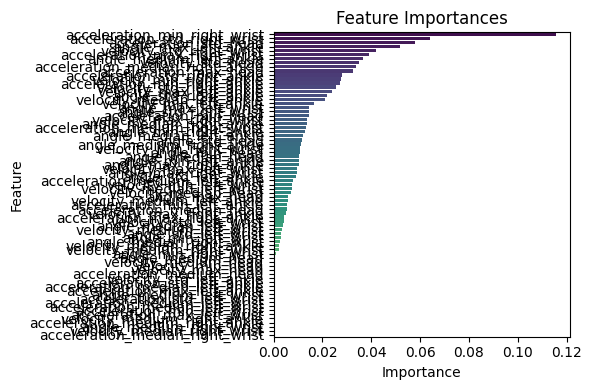

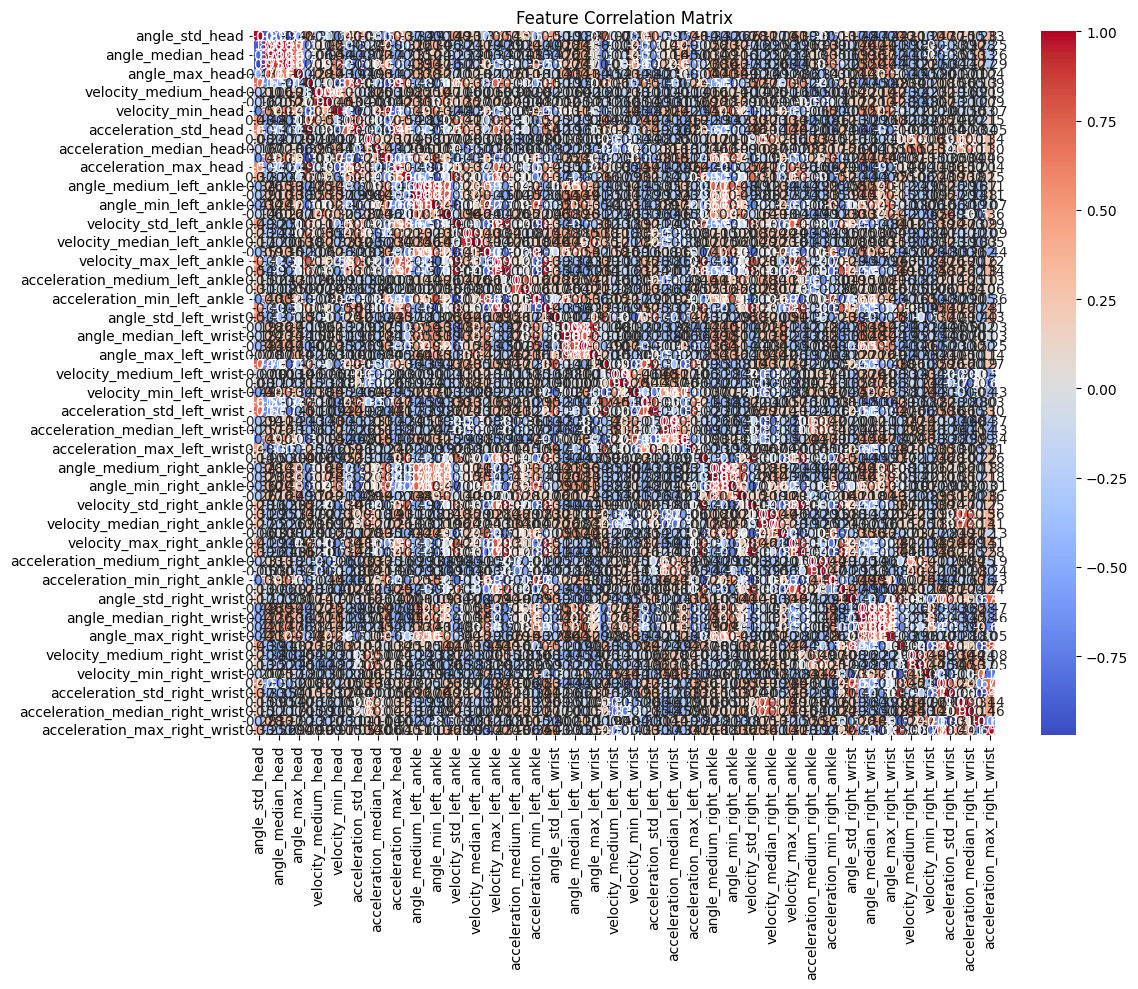

In [96]:
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [97]:
# Separate classes
df_direct = df_all[df_all['Classification'] == 'direct']
df_indirect = df_all[df_all['Classification'] == 'indirect']

# Resample to balance classes
df_direct_resampled = resample(df_direct, replace=True, n_samples=len(df_indirect), random_state=42)
df_balanced = pd.concat([df_direct_resampled, df_indirect])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

### **Try XGBoost Model**

              precision    recall  f1-score   support

      direct       1.00      1.00      1.00         3
    indirect       1.00      1.00      1.00         4

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



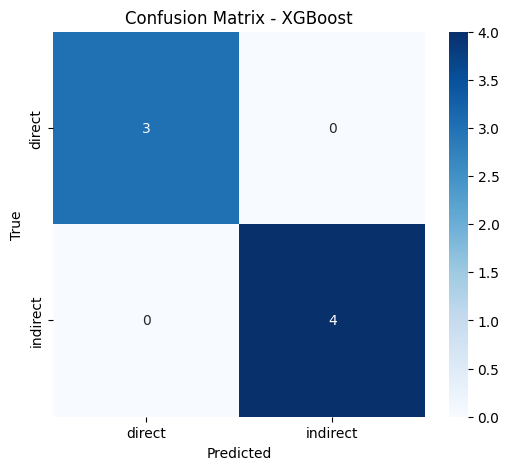

Feature Importances (XGBoost):
acceleration_median_right_ankle: 0.4557
acceleration_min_right_wrist: 0.3534
acceleration_std_right_wrist: 0.0472
velocity_min_left_wrist: 0.0356
velocity_medium_left_wrist: 0.0348
velocity_medium_right_wrist: 0.0343
velocity_median_left_ankle: 0.0289
velocity_std_left_wrist: 0.0084
velocity_max_left_ankle: 0.0017
angle_std_head: 0.0000
angle_medium_head: 0.0000
angle_median_head: 0.0000
angle_min_head: 0.0000
angle_max_head: 0.0000
velocity_std_head: 0.0000
velocity_medium_head: 0.0000
velocity_median_head: 0.0000
velocity_min_head: 0.0000
velocity_max_head: 0.0000
acceleration_std_head: 0.0000
acceleration_medium_head: 0.0000
acceleration_median_head: 0.0000
acceleration_min_head: 0.0000
acceleration_max_head: 0.0000
angle_std_left_ankle: 0.0000
angle_medium_left_ankle: 0.0000
angle_median_left_ankle: 0.0000
angle_min_left_ankle: 0.0000
angle_max_left_ankle: 0.0000
velocity_std_left_ankle: 0.0000
velocity_medium_left_ankle: 0.0000
velocity_min_left_ankl

C:\Users\asus\AppData\Local\Temp\ipykernel_26852\1569712675.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


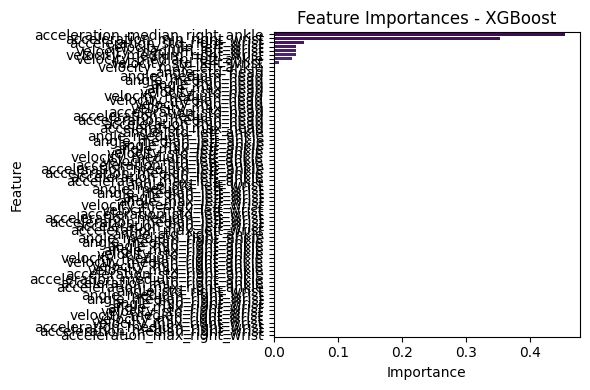

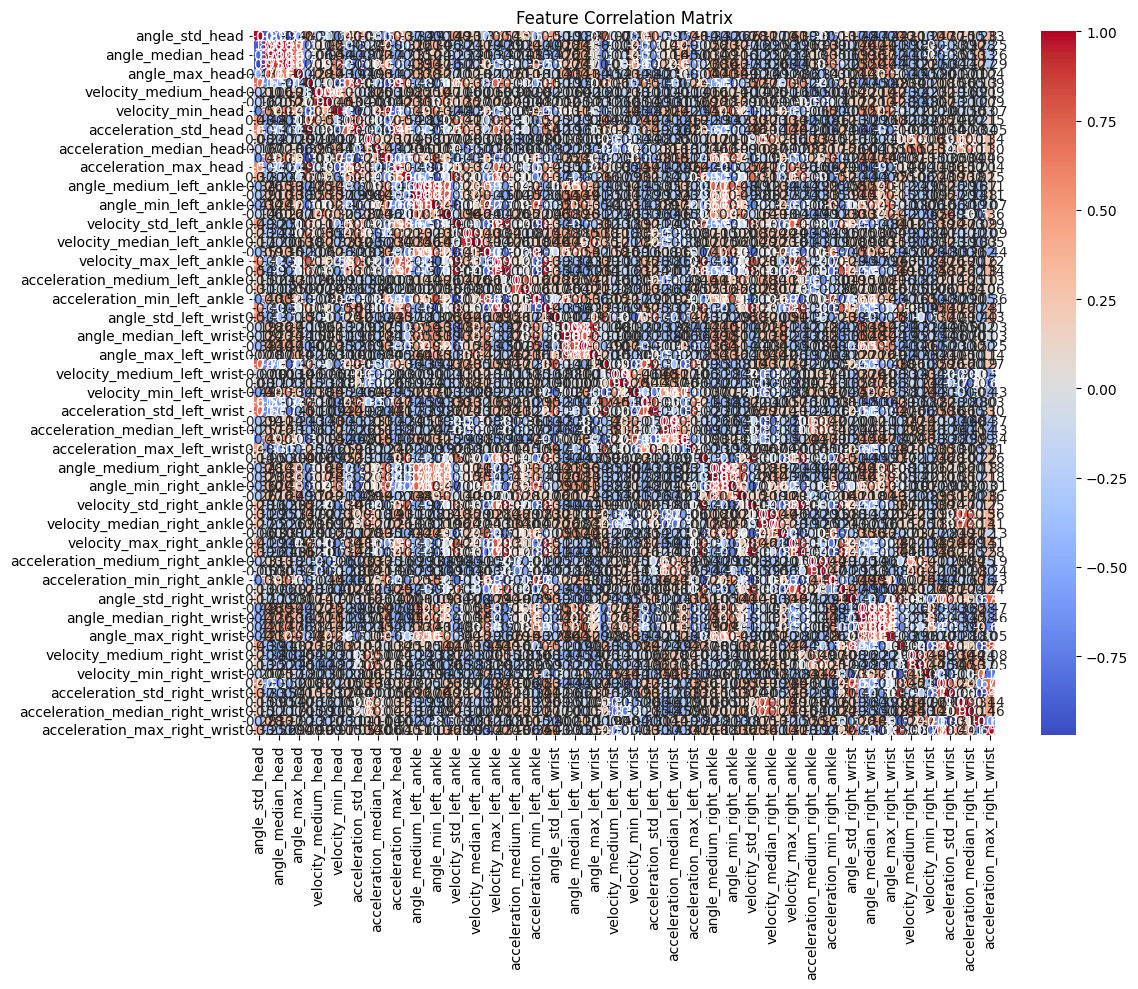

In [98]:
# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train_encoded)

# Predict and evaluate
y_pred_encoded = xgb.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Feature importances
importances = xgb.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances (XGBoost):")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances - XGBoost")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()